In [13]:
from data import SyntheticPV
from models import ApproximatePVLFM, ApproximateGP
from pv_plot import plot_lfm
from data.utils import print_lfm_param_table


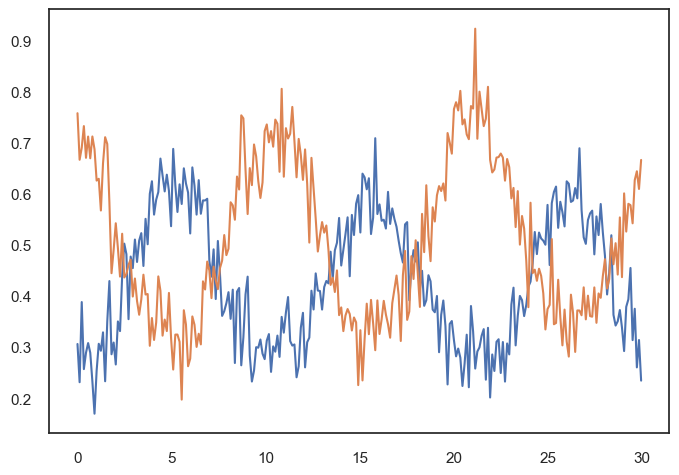

In [9]:
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'Arial'
dataset = SyntheticPV(num_discrete=8)
plt.plot(dataset.times, dataset.pv, label='PV')
plt.plot(dataset.times, dataset.cloud, label='Cloud')

In [10]:
from gpytorch.means import ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from alfi.configuration import VariationalConfiguration

num_outputs = 1
gp_config = {
    'type' : 'stochastic',
    'name' : 'cholesky',
    'jitter' : 1e-6,
}
gp_model = ApproximateGP(dataset=dataset,
                         mean=ZeroMean(),
                         covar=ScaleKernel(RBFKernel()),
                         likelihood=GaussianLikelihood(),
                         config=gp_config)

lfm = ApproximatePVLFM(dataset=dataset,
                       num_outputs=num_outputs,
                       gp_model=gp_model,
                       config=VariationalConfiguration(num_samples=70))

In [11]:
lfm.fit(n_iter=250, lr=0.2)

Iter 10/250, Loss: 0.3520960550990646
Iter 20/250, Loss: -0.7484303535172119
Iter 30/250, Loss: -0.9718785725542991
Iter 40/250, Loss: -1.1409422962757754
Iter 50/250, Loss: -1.1478734902720769
Iter 60/250, Loss: -1.1872917798188702
Iter 70/250, Loss: -1.1846344050459696
Iter 80/250, Loss: -1.1850974670486656
Iter 90/250, Loss: -1.201054109182496
Iter 100/250, Loss: -1.2066321152452777
Iter 110/250, Loss: -1.210848952700492
Iter 120/250, Loss: -1.2064832410370896
Iter 130/250, Loss: -1.2143887014031367
Iter 140/250, Loss: -1.21524651619621
Iter 150/250, Loss: -1.2100808909911585
Iter 160/250, Loss: -1.21276694397224
Iter 170/250, Loss: -1.1950398955831616
Iter 180/250, Loss: -1.2129920763812325
Iter 190/250, Loss: -1.2112578813408952
Iter 200/250, Loss: -1.214764112409544
Iter 210/250, Loss: -1.2048033650301675
Iter 220/250, Loss: -1.206814675416452
Iter 230/250, Loss: -1.2123638315399405
Iter 240/250, Loss: -1.213925807473938
Iter 250/250, Loss: -1.2120082071287868


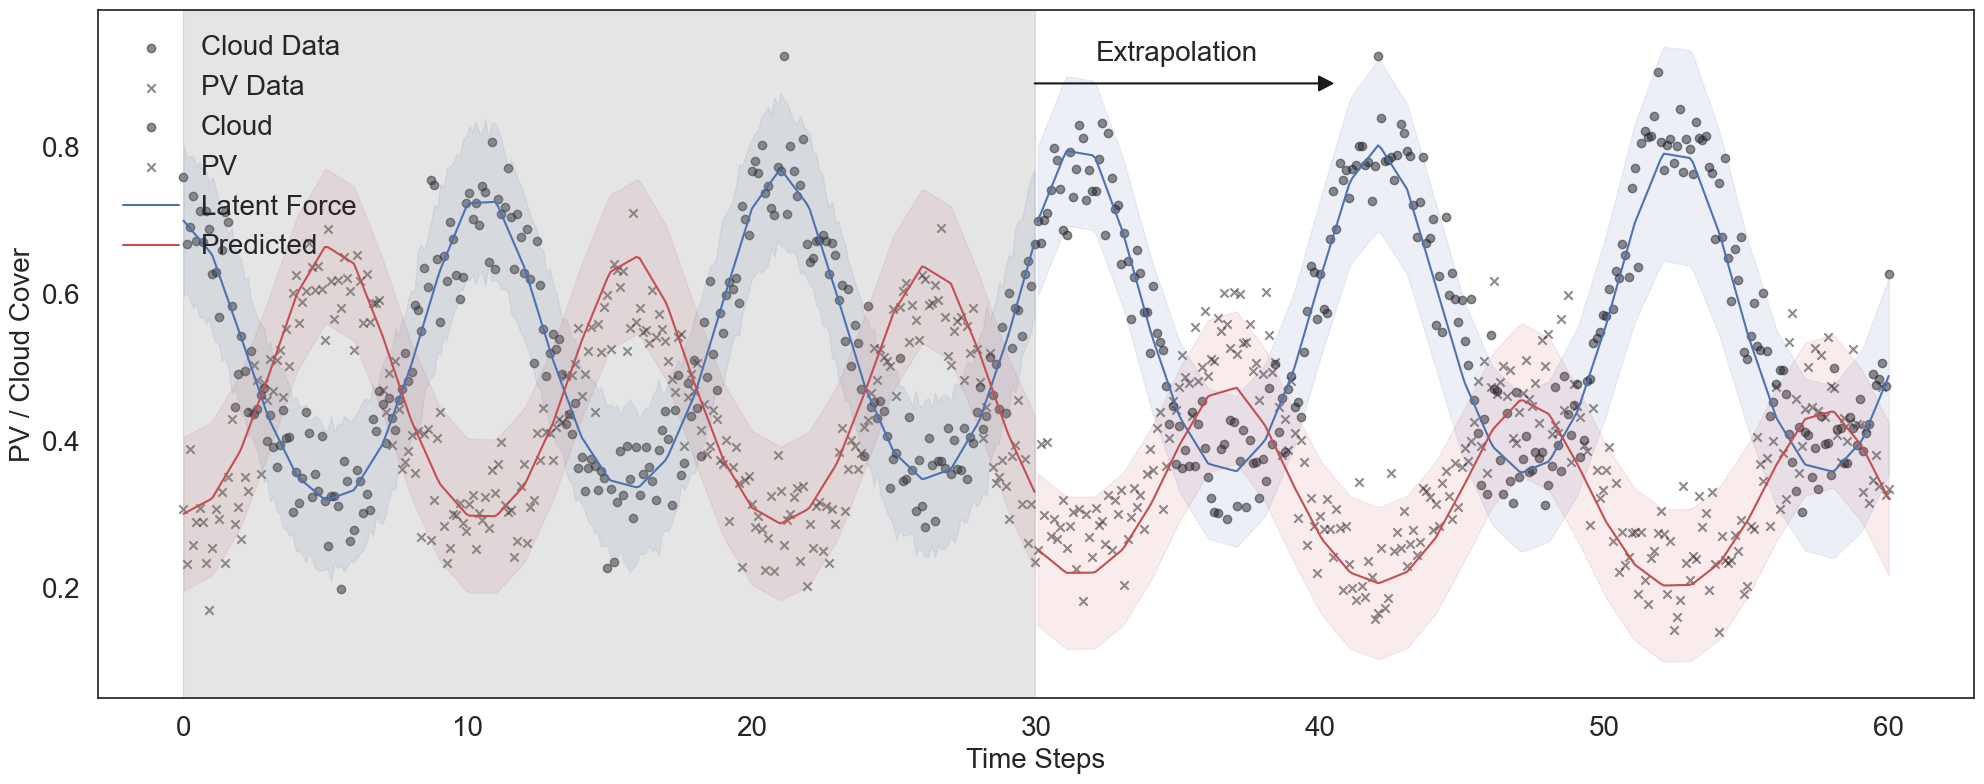

In [12]:
plot_lfm(lfm, dataset)

In [14]:
print_lfm_param_table(lfm, dataset)

--------------------------------------------------
| Parameter  	 | True 	 |  Learned 	 |
--------------------------------------------------
|  a 		 |  0.004 	 | 0.002 	 |
--------------------------------------------------
|  b 		 |  0.236 	 | 0.244 	 |
--------------------------------------------------
|  c 		 |  0.190 	 | 0.190 	 |
--------------------------------------------------
